# 2. Introduction to Deep Learning

Deep Learning is a machine learning paradigm which utilises deep neural networks. It is often said that neural networks are similar to how our brains work. They aren't. However, they are an enormously versatile algorithm now being used in miriad ways across society. Optimisation via gradient descent is at the heart of deep learning, so much so that it is increasingly being refered to as **differentiable computing**, which encompasses much more than neural networks. What we call it doesn't really matter though, and there is something intutive about viewing these algorithms as networks. Therefore, this notebook will introduce them as such, and do so utilising the `tensorflow` library.

### Required Packages

In [1]:
# REQUIRED PACAKGES
# ! pip install numpy
# ! pip install matplotlib
# ! pip install tensorflow==2.2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

### Data

In [2]:
X = np.load("./data/single_cell_features.npy")
labels = np.load("./data/single_cell_labels.npy")

label_dict = { 0 : "α-cells", 
               1 : "β-cells",
               2 : "ε-cells",
               3 : "δ-cells"
             }

color_dict = { 0 : (185/255, 79/255, 83/255),
               1 : (49/255, 104/255, 142/255),
               2 : (243/255, 121/255, 41/255),
               3 : (53/255, 183/255, 121/255)
            }

color_map = ListedColormap(colors=color_dict.values(), name='from_list', N=4)

colors = [color_dict[l] for l in labels]

Consider the plot below. It shows how different gene expression values for two genes in a single-cell sequencing experiment of pancreas tissue reveal cell subtypes. We will learn how to predict the subtype of a cell based on these expression values. To do to that we will use a neural network. 

![Pancreas Plot](./assets/pancreas_plot.png)

Building upon the previous notebook, we can think of the combination of linear and non-linear transformations *e.g.*  $\sigma(wx + b))$ as the fundamental building-block of neural networks. We can depict them as follows:

![neuron](./assets/neuron.png)

where $a$ represents the **activation function**, which in this case is the sigmoid function. We can refer to this single abstraction as either a **neuron**, **node** or **unit**. We also saw that for the linear component can have an arbitrary number of inputs such as $\sigma(w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + b))$. We can depict that as:

![multi-input neuron](./assets/multi_input_neuron.png)


The exicting part is that there is no limit to the ways in which we can connect neurons to each other. We can add depth (more layers) and width (more neurons) as follows:


![neural network](./assets/neural_network.png)


You can see that quite quickly the number of parameters increases, since each line connecting two neurons indicates a weight, typically given a number of the width and depth (layer) e.g $w_{2, 1}$ is weight 1 at layer 2. Layers which are full-connected to other neurons are called **dense** layers. Also, neurons/layers that are between the input and output layers of the network are called **hidden layers**. 

We will now build a neural network with Tensorflow. Fortunately, Tensorflow takes care of all the weights, gradients updates for us. We only need to specify the high-level details to make it work.

In [3]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [4]:
# Clear compuational graph
tf.keras.backend.clear_session()

# Create input layer that takes 1 input
model_in = Input(shape=(2, ), name="Input_Layer")

# Create and link a dense/fully-connected layer with a width of 8 neurons (all non-linear)
a = Dense(units=8, activation="sigmoid", name="Hidden_Layer_1")(model_in)

# Create and link a dense/fully-connected layer with a width of 1 (linear)
model_out = Dense(units=4, activation="softmax", name="Output_Layer")(a)

# wrap into a model
model = Model(inputs=[model_in], outputs=[model_out], name="Neural_Network")

# Show the details of the network
model.summary()

Model: "Neural_Network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 8)                 24        
_________________________________________________________________
Output_Layer (Dense)         (None, 4)                 36        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


The `.summary()` method gives us an overview of the model. Importantly we can see the number of parameters. The `Hidden_Layer_1` has 24 parameters. This is because we have $\{w_{1,1}, ..., w_{1,16} \}$ as well as $\{b_{1,1}, ..., b_{1,8}\}$.  The `Output_layer` has 36 parameters, with $ 4 \times 8$ $ws$ + $\{b_{2, 1}, b_{2, 2}, b_{2, 3}, b_{2, 4} \}$ bias terms. The final activation is called the **softmax** activation function, and performs a non-linear scaling of the 4 outputs neurons so that the largest output corresponds to the class prediction, scaled between $0$ and $1$, often interpreted as a probability. The function defined for a given output nueron $i$ is:

$$
\sigma(z)_i = \dfrac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \text{ for $i=1, ..., K$} 
$$

where $K$ is the number of output neurons. In this case, $K=4$.

We need to pick an **optimisation algorithm** and a learning rate, as well as a **loss function**. For this loss we will use what is called **categorical cross-entropy**, which is very common for multi-class classification. We do this as follows:

In [5]:
# Stochastic Gradient Descent (the most basic)
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

In [6]:
# Prepares model for training - also track accuracy
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["acc"])

Entropy is used to describe probability distributions. To measure our predictions as such as need to convert them into a probability distribution. We do this using **one-hot encoding**. It simply means to assign the class prediction a probability of $1$ and the other classes a probabiliyt of $0$. e.g.

```python
y_true = 2
y_true_one_hot = [0., 0., 1., 0.]
```

To do this for the whole data set we can use the `tf.keras.backend.one_hot()` function.

In [7]:
y = tf.keras.backend.one_hot(labels, num_classes=4)

In [8]:
y.shape

TensorShape([500, 4])

We can now begin training. We can do this several ways, the most common being the `.fit()` method. However, to help visualise the progress we will instead use the `.train_on_batch()` method.

2951/3000 [============================>.] - ETA: 0s

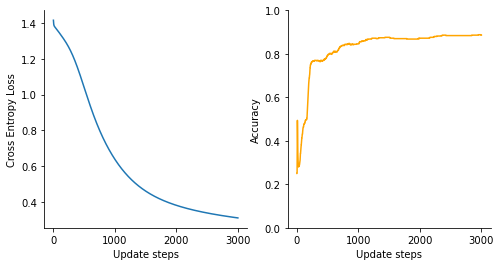

In [9]:
# Training
count = 0
STEPS = 3000
progress = tf.keras.utils.Progbar(STEPS)

losses = []
accuracy = []
for step in range(STEPS):
    
    # Update progress
    progress.update(step)
    
    # Perform single update of gradient descent
    loss, acc = model.train_on_batch(x=X, y=y)
    
    # Save metrics
    losses.append(loss)
    accuracy.append(acc)
    
    
#     ----- OPTIONAL ------ #
#     Visualise decision boundaries

#     # create a mesh to plot in
#     xx1, xx2 = np.meshgrid(np.arange(1, 3, 0.025),
#                          np.arange(0.8, 3, 0.025))
#     grid = np.c_[xx1.ravel(), xx2.ravel()]

# ---------------------------------------------- #
#     if step % 50 == 0:
        
#         z = np.argmax(model.predict(grid), axis=-1)
#         z = z.reshape(xx1.shape)

#         plt.contourf(xx1, xx2, z, cmap=color_map)
#         plt.scatter(X[:, 0], X[:, 1], marker=".", color="grey")

#         plt.xlabel("$Gene_1$")
#         plt.ylabel("$Gene_2$")

#         plt.savefig(f"./out/plot_{count:03}.png")

#         plt.close()
        
#         count += 1
    
    
# Show results
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(range(STEPS), losses)
ax[0].set_xlabel("Update steps")
ax[0].set_ylabel("Cross Entropy Loss")
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

ax[1].plot(range(STEPS), accuracy, color="orange")
ax[1].set_xlabel("Update steps")
ax[1].set_ylabel("Accuracy")
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_ylim(0, 1)

plt.show()

We can now predict the inputs and visualise the classifications using the `np.argmax()` function.

In [10]:
# Predict all inputs
y_pred = model.predict(X)

# Find the position of the largest value
label_pred = np.argmax(y_pred, axis=-1)

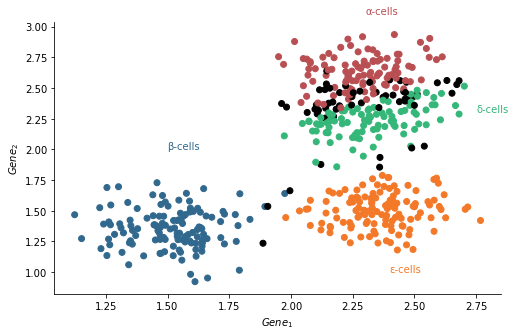

In [11]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], 
            c=[color_dict[l] if l == y else "black" for l, y in zip(label_pred, labels)])
plt.xlabel("$Gene_1$")
plt.ylabel("$Gene_2$")
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.text(2.3, 3.1, label_dict[0], color=color_dict[0])
plt.text(1.5, 2, label_dict[1], color=color_dict[1])
plt.text(2.4, 1, label_dict[2], color=color_dict[2])
plt.text(2.75, 2.3, label_dict[3], color=color_dict[3])

plt.show()

We can see that the classes have been predicted reasonably accurately. We can also see the decision boundaries change over the course of training, leading to the final classifier.

![four class decision boundary](./assets/four_class_decision_boundary.gif)


Despite the useful classification performance, the decision boundaries demonstrate that the neural network is only learning an approximation of the original function. We know that ε-cells form a cluster, not an expansive region to the bottom right of the plot as shown in the graph above. Of course, the real test of your model comes when you test it on **unseen data**; data which was not used in training. This is how we validate models and check if they can **generalise** to real-world data. The problem of **over-fitting** to the training data is a topic in itself, but it is straight-forward to understand. Has your model approximated the real-world function?

# Conclusion

Here we have learned what a neural network is, and how we can combine nuerons in endless ways, with multiple inputs, layers and outputs. The `tensorflow` library takes care of the optimization via gradient descent and we can focus on the high-level details of the network. For multi-class classification we can use the **softmax** activation function and measure the loss using **categorical cross entropy** by converting our labels into **one-hot encoded distributions**. We can also track metrics such as **accuracy** automatically. 

The great thing about neural networks is that with enough data and enough computing memory to store parameters, we can learn highly complex functions. But importantly, we must **validate** our model using an external data set.

In the next notebook we will look at how we can use neural networks to classify more structured data such as images.